## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

### 不同optimizer、不同層數以及不同 Dropout rate 對訓練的效果影響 
* 以3層隱藏層的網路模型SGD建模時，Dropout rate = 0.1 時，模型準確度較高 (acc: 0.6121)
* 以5層隱藏層的網路模型SGD建模時，Dropout rate = 0.1 時，模型準確度較高 (acc: 0.5930)
* 以5層隱藏層的網路模型Adam建模時，Dropout rate = 0.1 時，模型準確度較高 (acc: 0.5728)

### Overfitting觀察
* 在Dropout rate = 0.1時雖然準確度最高，但是在高epochs時，可以觀察到train&valid data的準確度落差漸大。(overfitting現象)
* 在Dropout rate = 0.3時，在高epochs可以觀察到train&valid data的準確度趨近
* 在資料accuracy及overfitting間需要小心做取捨，Dropout rate = 0.2是很不錯的選擇

### SGD v.s. Adam
* SGD整體準確度較Adam好
* SGD在train&valid data準確度落差較Adam好

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

## 1. 觀察不同層數以及不同 Dropout rate 對訓練的效果
#### 1.1 3層隱藏層與不同dropout rate的關係 (hidden=3)

In [5]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1, 0.2, 0.3]

In [7]:
results = {}

for dp in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout = %.2f" % (dp))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dp)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-Dropout-%s" % str(dp)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0804 11:45:34.303688 41612 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0804 11:45:34.304688 41612 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 11:45:34.321689 41612 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 11:45:34.321689 41612 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 11:45:34.324689 41612 depr

Experiment with Dropout = 0.10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)     

W0804 11:45:34.537701 41612 deprecation.py:323] From E:\Users\moon\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 181us/step - loss: 2.0741 - acc: 0.2398 - val_loss: 1.8821 - val_acc: 0.3357
Epoch 2/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.8787 - acc: 0.3260 - val_loss: 1.7911 - val_acc: 0.3745
Epoch 3/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.7982 - acc: 0.3582 - val_loss: 1.7138 - val_acc: 0.3956
Epoch 4/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.7392 - acc: 0.3831 - val_loss: 1.6640 - val_acc: 0.4158
Epoch 5/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.6927 - acc: 0.3997 - val_loss: 1.6336 - val_acc: 0.4322
Epoch 6/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.6568 - acc: 0.4105 - val_loss: 1.5991 - val_acc: 0.4403
Epoch 7/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.6270 - acc: 0.4217 - val_loss: 1.5692 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 179us/step - loss: 2.1619 - acc: 0.1958 - val_loss: 1.9563 - val_acc: 0.3130
Epoch 2/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.9569 - acc: 0.2918 - val_loss: 1.8365 - val_acc: 0.3510
Epoch 3/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.8737 - acc: 0.3248 - val_loss: 1.7749 - val_acc: 0.3697
Epoch 4/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.8213 - acc: 0.3464 - val_loss: 1.7307 - val_acc: 0.3867
Epoch 5/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.7764 - acc: 0.3666 - val_loss: 1.6824 - val_acc: 0.4097
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.7442 - acc: 0.3779 - val_loss: 1.6479 - val_acc: 0.4236
Epoch 7/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7157 - acc: 0.3882 - val_loss: 1.6179 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 177us/step - loss: 2.1961 - acc: 0.1779 - val_loss: 2.0154 - val_acc: 0.2871
Epoch 2/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.0247 - acc: 0.2513 - val_loss: 1.8976 - val_acc: 0.3369
Epoch 3/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.9485 - acc: 0.2912 - val_loss: 1.8374 - val_acc: 0.3540
Epoch 4/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.8980 - acc: 0.3107 - val_loss: 1.7876 - val_acc: 0.3731
Epoch 5/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.8547 - acc: 0.3321 - val_loss: 1.7471 - val_acc: 0.3883
Epoch 6/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.8213 - acc: 0.3439 - val_loss: 1.7129 - val_acc: 0.3989
Epoch 7/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.7885 - acc: 0.3566 - val_loss: 1.6818 - 

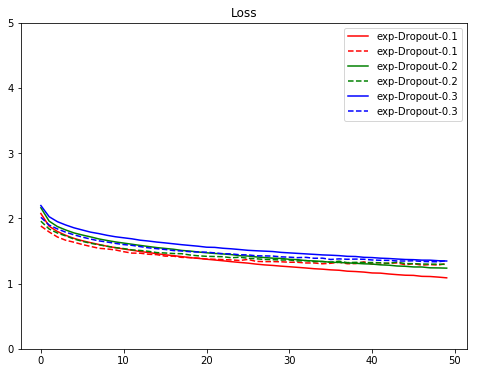

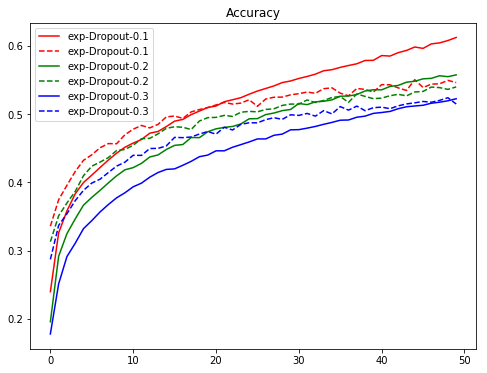

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 1. 觀察不同層數以及不同 Dropout rate 對訓練的效果
#### 1.2 5層隱藏層與不同dropout rate的關係 (hidden=5)

In [9]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1, 0.2, 0.3]

In [11]:
results = {}

for dp in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout = %.2f" % (dp))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dp)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-Dropout-%s" % str(dp)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout = 0.10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)     

50000/50000 [==============================] - 10s 192us/step - loss: 1.1615 - acc: 0.5836 - val_loss: 1.3090 - val_acc: 0.5380
Epoch 46/50
50000/50000 [==============================] - 9s 190us/step - loss: 1.1584 - acc: 0.5844 - val_loss: 1.3156 - val_acc: 0.5387
Epoch 47/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.1470 - acc: 0.5872 - val_loss: 1.3220 - val_acc: 0.5346
Epoch 48/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.1394 - acc: 0.5911 - val_loss: 1.2976 - val_acc: 0.5418
Epoch 49/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.1387 - acc: 0.5912 - val_loss: 1.3130 - val_acc: 0.5420
Epoch 50/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.1257 - acc: 0.5930 - val_loss: 1.3095 - val_acc: 0.5350
Experiment with Dropout = 0.20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (Input

50000/50000 [==============================] - 9s 182us/step - loss: 1.3664 - acc: 0.5128 - val_loss: 1.3677 - val_acc: 0.5054
Epoch 40/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.3658 - acc: 0.5094 - val_loss: 1.3631 - val_acc: 0.5094
Epoch 41/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3582 - acc: 0.5132 - val_loss: 1.3655 - val_acc: 0.5111
Epoch 42/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3529 - acc: 0.5126 - val_loss: 1.3629 - val_acc: 0.5121
Epoch 43/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3434 - acc: 0.5162 - val_loss: 1.3566 - val_acc: 0.5166
Epoch 44/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.3357 - acc: 0.5198 - val_loss: 1.3520 - val_acc: 0.5155
Epoch 45/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.3350 - acc: 0.5208 - val_loss: 1.3492 - val_acc: 0.5180
Epoch 46/50
50000/50000 [==============

50000/50000 [==============================] - 9s 185us/step - loss: 1.5547 - acc: 0.4422 - val_loss: 1.4680 - val_acc: 0.4731
Epoch 34/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.5492 - acc: 0.4433 - val_loss: 1.4620 - val_acc: 0.4759
Epoch 35/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.5456 - acc: 0.4445 - val_loss: 1.4629 - val_acc: 0.4745
Epoch 36/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.5414 - acc: 0.4441 - val_loss: 1.4590 - val_acc: 0.4745
Epoch 37/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.5394 - acc: 0.4454 - val_loss: 1.4511 - val_acc: 0.4847
Epoch 38/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.5313 - acc: 0.4495 - val_loss: 1.4485 - val_acc: 0.4807
Epoch 39/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.5224 - acc: 0.4536 - val_loss: 1.4610 - val_acc: 0.4820
Epoch 40/50
50000/50000 [==============

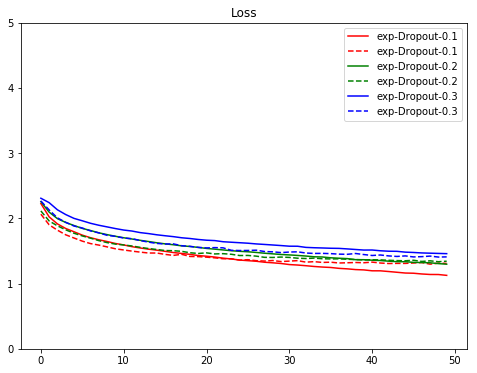

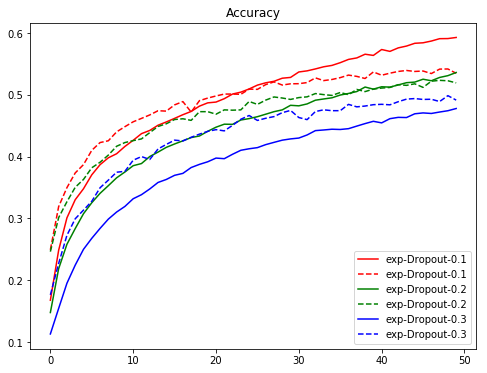

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果 (hidden=5)

In [13]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1, 0.2, 0.3]

In [17]:
results = {}

for dp in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout = %.2f" % (dp))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dp)
    model.summary()
    optimizer = keras.optimizers.adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-Dropout-%s" % str(dp)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout = 0.10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)     

50000/50000 [==============================] - 12s 233us/step - loss: 1.2019 - acc: 0.5655 - val_loss: 1.3517 - val_acc: 0.5281
Epoch 46/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.2018 - acc: 0.5662 - val_loss: 1.3669 - val_acc: 0.5153
Epoch 47/50
50000/50000 [==============================] - 12s 244us/step - loss: 1.1849 - acc: 0.5700 - val_loss: 1.3469 - val_acc: 0.5275
Epoch 48/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.1841 - acc: 0.5727 - val_loss: 1.3509 - val_acc: 0.5280
Epoch 49/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.1826 - acc: 0.5730 - val_loss: 1.3653 - val_acc: 0.5263
Epoch 50/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.1805 - acc: 0.5728 - val_loss: 1.3503 - val_acc: 0.5291
Experiment with Dropout = 0.20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (

50000/50000 [==============================] - 13s 264us/step - loss: 1.4857 - acc: 0.4663 - val_loss: 1.4708 - val_acc: 0.4833
Epoch 40/50
50000/50000 [==============================] - 12s 250us/step - loss: 1.4800 - acc: 0.4705 - val_loss: 1.4503 - val_acc: 0.4885
Epoch 41/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.4864 - acc: 0.4672 - val_loss: 1.4602 - val_acc: 0.4853
Epoch 42/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.4783 - acc: 0.4728 - val_loss: 1.4416 - val_acc: 0.4936
Epoch 43/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.4750 - acc: 0.4725 - val_loss: 1.4501 - val_acc: 0.4879
Epoch 44/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.4691 - acc: 0.4765 - val_loss: 1.4504 - val_acc: 0.4835
Epoch 45/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.4682 - acc: 0.4763 - val_loss: 1.4343 - val_acc: 0.4906
Epoch 46/50
50000/50000 [=======

50000/50000 [==============================] - 12s 236us/step - loss: 1.7007 - acc: 0.3869 - val_loss: 1.6606 - val_acc: 0.4205
Epoch 34/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.6879 - acc: 0.3907 - val_loss: 1.6249 - val_acc: 0.4317
Epoch 35/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.6897 - acc: 0.3889 - val_loss: 1.6493 - val_acc: 0.4245
Epoch 36/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.6905 - acc: 0.3896 - val_loss: 1.6399 - val_acc: 0.4269
Epoch 37/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.6888 - acc: 0.3922 - val_loss: 1.6292 - val_acc: 0.4235
Epoch 38/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.6802 - acc: 0.3930 - val_loss: 1.6624 - val_acc: 0.4218
Epoch 39/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.6798 - acc: 0.3927 - val_loss: 1.6224 - val_acc: 0.4297
Epoch 40/50
50000/50000 [=======

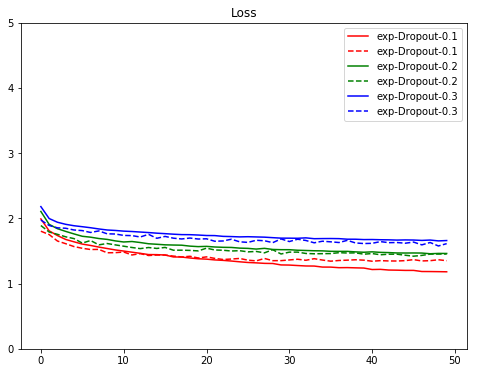

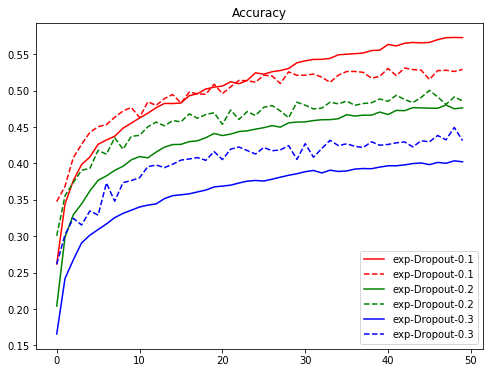

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()